In [100]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import MetaTrader5 as mt5
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

In [101]:
list_tickers = ['EWJ', 'EWT', 'EWY', 'EWZ', 'EZU', 'INDA', 'ITOT', 'MCHI']
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2020, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
if mt5.initialize():
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, time_from, time_to) for ticker in list_tickers]
    df = pd.DataFrame(
            pd.to_datetime(max(database, key=len)['time'], unit='s'),
            columns=['time']
        )
    for ticker, col in zip(list_tickers, database):
        df[ticker] = pd.DataFrame(col['close'])
    df = df.set_index('time', drop=True)
    data = df.dropna().pct_change().dropna()

In [102]:
def MV_criterion(weights, data):
    """
    Ountput:
        optimización del criterio (media-varianza) de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        data(type ndarray numpy): Retornos de los activos
    """
    # Parámetros
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25/100
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media y la volatilidad de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    # Calcular el criterio
    criterion = (Wbar**(1-Lambda)/(1+Lambda)+
                 Wbar**(-Lambda)*W*mean-
                 Lambda/2*Wbar**(-1-Lambda)*
                 W**2*std**2
                 )
    criterion = -criterion
    return criterion

In [103]:
def SK_criterion(weights, data):
    """
    Ountput:
        optimización del criterio (media-varianza sesgo kurtosis) de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        data(type ndarray numpy): Retornos de los activos
    """
    # Parámetros
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media, la volatilidad, el sesgo y la curtosis de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    skewness = skew(portfolio_return, 0)
    kurt = kurtosis(portfolio_return, 0)
    # Calcular el criterio
    criterion = Wbar**(1 - Lambda) / (1 + Lambda) + Wbar**(-Lambda)\
        * W * mean - Lambda / 2 * Wbar**(-1 - Lambda) * W**2 * std**2\
        + Lambda * (Lambda + 1) / (6) * Wbar**(-2 - Lambda) * W**3 * skewness\
        - Lambda * (Lambda + 1) * (Lambda + 2) / (24) * Wbar**(-3 - Lambda)\
        * W**4 * kurt
    criterion = -criterion
    return criterion

In [104]:
def SR_criterion(weight, data):
    """
    Ountput:
        optimización del criterio (ratio de Sharpe) de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        data(type ndarray numpy): Retornos de los activos
    """
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(data, np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media y la volatilidad de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std=np.std(portfolio_return, axis=0)
    # Calcular el opuesto al ratio de Sharpe
    sharpe = mean / std
    sharpe=-sharpe
    return sharpe

In [105]:
def SOR_criterion(weight, data):
    """
    Ountput:
        optimización del criterio (ratio de Sortino) de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        data(type ndarray numpy): Retornos de los activos
    """
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(data, np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media y la volatilidad de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return[portfolio_return < 0], axis=0)
    # Calcular el opuesto al ratio de Sortino
    Sortino = mean / std
    Sortino = -Sortino
    return Sortino

In [106]:
split = int(0.7*len(data))
train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]
# Encontrar el número de activos
n = data.shape[1]
# Inicialización de los pesos
x0=np.ones(n)
# Restricciones del problema de optimización
cons = [{'type': 'eq',
         'fun': lambda x: sum(abs(x))-1}]
# Establecer los límites
Bounds = [(0, 1) for i in range(0, n)]
# Resolución de los problemas de optimización
res_MV = minimize(MV_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
res_SK = minimize(SK_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
res_SR = minimize(SR_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
res_SOR = minimize(SOR_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
# ResultadoS
X_MV = res_MV.x
X_SK = res_SK.x
X_SR = res_SR.x
X_SOR = res_SOR.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2484496949524077
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19.639457398624305
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.023151338151183417
            Iterations: 11
            Function evaluations: 99
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.02691564968193577
            Iterations: 10
            Function evaluations: 92
            Gradient evaluations: 10


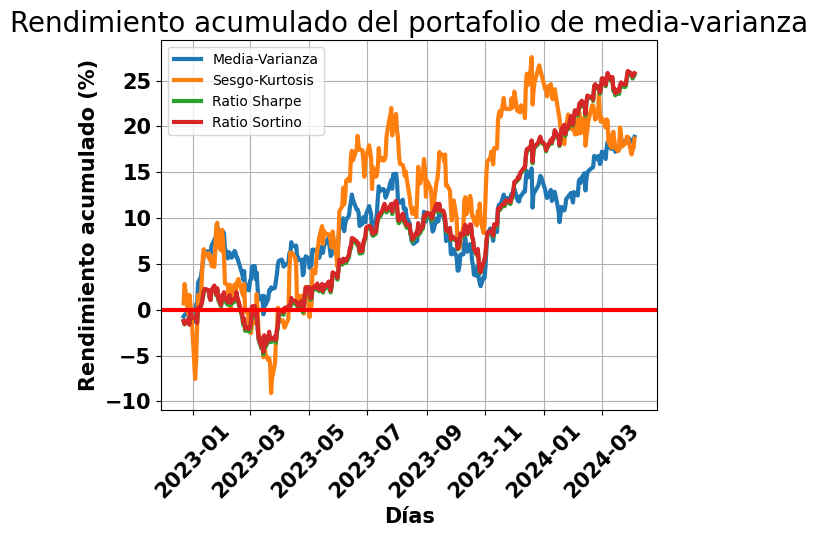

In [107]:
# Calcular la retabilidad acumulada de la cartera
portfolio_return_MV = np.multiply(test_set, np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)
portfolio_return_SK = np.multiply(test_set, np.transpose(X_SK))
portfolio_return_SK = portfolio_return_SK.sum(axis=1)
portfolio_return_SR = np.multiply(test_set, np.transpose(X_SR))
portfolio_return_SR = portfolio_return_SR.sum(axis=1)
portfolio_return_SOR = np.multiply(test_set, np.transpose(X_SOR))
portfolio_return_SOR = portfolio_return_SOR.sum(axis=1)
portfolio_strategies = pd.concat(
   [
      portfolio_return_MV,
      portfolio_return_SK,
      portfolio_return_SR,
      portfolio_return_SOR
   ], axis=1)
portfolio_strategies.columns = columns=[
   "Media-Varianza", 
   "Sesgo-Kurtosis", 
   "Ratio Sharpe",
   "Ratio Sortino"]

# Representar el CM
for column in portfolio_strategies.columns:
    plt.plot(np.cumsum(portfolio_strategies[column]) * 100, linewidth=3, label=column)

plt.ylabel("Rendimiento acumulado (%)", size=15, fontweight='bold')
plt.xlabel("Días", size=15, fontweight='bold')
plt.xticks(rotation=45) 
plt.xticks(size=15, fontweight='bold')
plt.yticks(size=15, fontweight='bold')
plt.title("Rendimiento acumulado del portafolio de media-varianza", size=20)
plt.axhline(0, color='r', linewidth=3)
plt.legend(loc="upper left")
plt.grid(True)
plt.show()